# Simple Siamese Network Implementation

Implementation is done to get understanding of how contrastive learn work, which will help to implement FYP project

### Dataset

Used AT&T Dataset

Can Be Found At : https://www.kaggle.com/datasets/kasikrit/att-database-of-faces

In [1]:
TRAINING_PATH = "att_data/training"
TESTING_PATH = "att_data/testing"

### Configure and Import Required Libraries

In [2]:
%matplotlib inline

In [3]:
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Preparing Dataset

There are three persons in dataset. And each one containing 10 images. In order to train good neural network we need to precent class imbalance. Where we need to choose pair of images such that, 50% of images related to person and 50% images related to different person

Let's list all image paths and give tag

##### Train Dict

In [4]:
content_of_training_directory = os.listdir(TRAINING_PATH)
train_img_dict = []

for tag in content_of_training_directory:
    
    images_under_tag = os.listdir(TRAINING_PATH+"/"+tag)
    
    for image in images_under_tag:
        
        image_location = TRAINING_PATH+"/"+tag+"/"+image
        img = Image.open(image_location)
        
        img.convert("L")
        img.resize((100,100))
        
        transform = transforms.Compose([transforms.PILToTensor()])
        tensor = transform(img)
        train_img_dict.append((tensor, tag))

random.shuffle(train_img_dict)
train_img_dict[0]

(tensor([[[104, 106, 107,  ...,  99, 100,  97],
          [106, 106, 102,  ...,  96, 100,  99],
          [105, 104, 104,  ..., 101,  95,  94],
          ...,
          [152, 107,  93,  ...,  59,  52,  42],
          [144,  83, 107,  ...,  72,  63,  67],
          [115,  84, 128,  ...,  65,  59,  73]]], dtype=torch.uint8),
 's38')

#### Test Dict

In [5]:
content_of_training_directory = os.listdir(TESTING_PATH)
test_img_dict = []

for tag in content_of_training_directory:
    
    images_under_tag = os.listdir(TESTING_PATH+"/"+tag)
    
    for image in images_under_tag:
        
        image_location = TESTING_PATH+"/"+tag+"/"+image
        img = Image.open(image_location)
        
        img.convert("L")
        img.resize((100,100))
        
        transform = transforms.Compose([transforms.PILToTensor()])
        tensor = transform(img)
        test_img_dict.append((tensor, tag))

random.shuffle(test_img_dict)
test_img_dict[0]

(tensor([[[157, 152, 154,  ..., 152, 150, 151],
          [155, 152, 156,  ..., 151, 151, 150],
          [153, 153, 154,  ..., 152, 150, 151],
          ...,
          [105, 104, 115,  ..., 111, 113, 110],
          [115, 122, 146,  ..., 109, 113, 110],
          [135, 144, 157,  ..., 111, 108, 109]]], dtype=torch.uint8),
 's6')

Image Dict Contain Images And Tag as (PIL_IMAGE, TAG)

Now we need to make a batch with 50% similarity 

In [6]:
def load_a_batch(batchsize,img_dict):
    
    # Content -> List Of (Image_1_Tensor, Image_2_Tensor, Is_Similar_Boolean)
    output_list = []
    
    # Select Similar Images
    for i in range(batchsize//2):
        img_1 = random.choice(img_dict)
        while True:
            img_2 = random.choice(img_dict)
            if img_1[1]==img_2[1]:
                output_list.append((img_1[0],img_2[0],True))
                break
    
    # Select Dissimilar Images
    for i in range(batchsize//2,batchsize):
        img_1 = random.choice(img_dict)
        while True:
            img_2 = random.choice(img_dict)
            if img_1[1]!=img_2[1]:
                output_list.append((img_1[0],img_2[0],False))
                break
    
    # Shuffle
    random.shuffle(output_list)
    
    # Return
    return output_list
                

We need a function to view a batch

In [7]:
def batch_image(batch):
    list_of_vertical_joined = []
    is_similar = []
    for i in range(len(batch)):
        res = torch.cat((torch.squeeze(batch[i][0]), torch.squeeze(batch[i][1])), 0)
        list_of_vertical_joined.append(res)
        is_similar.append(batch[i][2])
    res = list_of_vertical_joined[0]
    for i in range(1,len(list_of_vertical_joined)): 
        res = torch.cat((res, list_of_vertical_joined[i]), 1)
    return transforms.ToPILImage()(res),is_similar

[False, False, True, True, False, False, True, False, True, True]


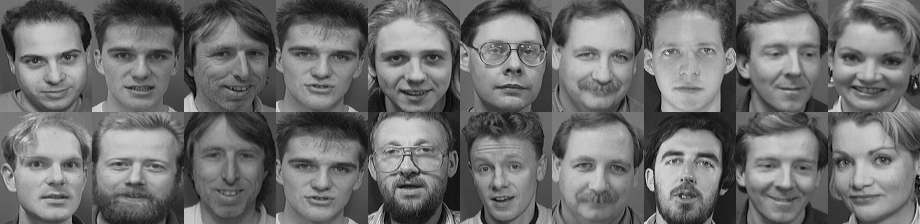

In [8]:
batch1 = load_a_batch(10,train_img_dict)
img,is_similar = batch_image(batch1)
print(is_similar)
img

In [9]:
def imshow(img, text=None):
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(img)
    plt.show() 

### Build Model

Here is how Siamese Network defined

![SiaMese Network Architecture](siamese.png)

In [10]:
class MySiameseNetwork(nn.Module):
    
    def __init__(self):
        super(MySiameseNetwork,self).__init__()
        
        self.cn_network = nn.Sequential(
            # Conv1
            nn.Conv2d(1,96,kernel_size =11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            
            # Conv2
            nn.Conv2d(96,256,kernel_size =5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            
            # Conv3
            nn.Conv2d(256,384,kernel_size =3, stride=1),
            nn.ReLU(),       
        )
        
        self.fc_network = nn.Sequential(            
            # FC 1 
            nn.Linear(768,1024),
            # FC 2
            nn.Linear(1024,256),
            # FC 2
            nn.Linear(256,2)                
        )
        
             
        
    def SendThroughNetwork(self,image):        
        out_cn = self.cn_network(image)
        shape = out_cn.shape
        flatten_out = out_cn.view(shape[0],-1)
        output = self.fc_network(flatten_out)
        return output
    
    def GetInputsAndLabels(self,batch):
        image_1_list=[]
        image_2_list=[]
        labels = []
        
        for img1,img2,label in batch:
            image_1_list.append(torch.unsqueeze(img1,0))
            image_2_list.append(torch.unsqueeze(img2,0))
            labels.append(torch.unsqueeze(torch.tensor(int(label)),0))
        
        return torch.cat(image_1_list,dim=0).float(),torch.cat(image_2_list,dim=0).float(),torch.cat(labels,dim=0).float()
    
    def forward(self,image_1,image_2):
        
        # Send Two Images Through Same Network
        output1 = self.SendThroughNetwork(image_1)
        output2 = self.SendThroughNetwork(image_2)
        
        return output1,output2
        

In [11]:
siamese_network = MySiameseNetwork()
image_1_batch,image_2_batch,labels_batch =siamese_network.GetInputsAndLabels(batch1)

In [12]:
image_2_batch.shape

torch.Size([10, 1, 112, 92])

In [13]:
x1,x2 = siamese_network(image_1_batch,image_2_batch)

### Define Loss

In [14]:
def ContastiveLoss(x1, x2, label, margin: float = 1.0):

    dist = torch.nn.functional.pairwise_distance(x1, x2)

    loss = (1 - label) * torch.pow(dist, 2) \
        + (label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
    loss = torch.mean(loss)

    return loss

In [15]:
ContastiveLoss(x1,x2,labels_batch)

tensor(0.4087, grad_fn=<MeanBackward0>)

### Function To Stack Batch

In [16]:
def stack(batch):
    img_1 = batch[0][0].unsqueeze(0).float()
    img_2 = batch[0][1].unsqueeze(0).float()
    labels = []
    for i in range(1,len(batch)):
        next_img = batch[i][0].unsqueeze(0)
        img_1 = torch.cat([img_1,next_img],dim=0).float()
    for i in range(1,len(batch)):
        next_img = batch[i][1].unsqueeze(0)
        img_2 = torch.cat([img_2,next_img],dim=0).float()
    for i in range(len(batch)):
        labels.append(torch.unsqueeze(torch.tensor(int(batch[i][2])),0).float())
    
    labels = torch.cat(labels, dim=0).float()
    
    return img_1,img_2,labels        

### Create Train Dataset

In [17]:
train_dataset = []
no_of_batches = 20
batch_size = 50

for i in range(no_of_batches):
    batch = load_a_batch(batch_size,train_img_dict)
    train_dataset.append(stack(batch))

### Create Validation Dataset

In [18]:
validation_dataset = []
no_of_batches = 10
batch_size = 30

for i in range(no_of_batches):
    batch = load_a_batch(batch_size,test_img_dict)
    validation_dataset.append(stack(batch))

### Train Model

In [19]:
neural_network = MySiameseNetwork()
loss_func = ContastiveLoss
opt = torch.optim.Adam(neural_network.parameters(), lr = 0.0005)

In [20]:
counter = []
train_history = []
val_history = []
iter_no    = 0

In [21]:
for epoch in range(10):
    i = 0
    for img_1,img_2,label in train_dataset:
        
        # Zero The Grads
        opt.zero_grad()
        
        # Get Outputs
        out1,out2 = neural_network(img_1,img_2)
        
        # Calc Loss
        loss = loss_func(out1,out2,label)
        
        # Calc Gradients
        loss.backward()
        
        # Update Weights
        opt.step()
        
        
        # Every 10 batch print result
        if i%10 ==0:
            val_loss = []
            for img_1,img_2,label in validation_dataset:
                
                # Get Outputs
                out1,out2 = neural_network(img_1,img_2)
        
                # Calc Loss
                val_loss.append(loss_func(out1,out2,label).item())
            
            val_loss_mean = sum(val_loss) / len(val_loss)
            print("Epoch No :",epoch,"iter :",i,"Current Loss:",loss.item(),"Validation Loss : ",val_loss_mean)
            iter_no+=10
            counter.append(iter_no)
            train_history.append(loss.item())
            val_history.append(val_loss_mean)
        i+=1

Epoch No : 0 iter : 0 Current Loss: 0.46750205755233765 Validation Loss :  90.50034980773925
Epoch No : 0 iter : 10 Current Loss: 0.4998623728752136 Validation Loss :  0.7657394051551819
Epoch No : 1 iter : 0 Current Loss: 0.540237545967102 Validation Loss :  0.506355682015419
Epoch No : 1 iter : 10 Current Loss: 0.41419804096221924 Validation Loss :  0.4210254728794098
Epoch No : 2 iter : 0 Current Loss: 0.3610725402832031 Validation Loss :  0.6267145156860352
Epoch No : 2 iter : 10 Current Loss: 0.3883932828903198 Validation Loss :  0.40769400596618655
Epoch No : 3 iter : 0 Current Loss: 0.3231580853462219 Validation Loss :  0.476996386051178
Epoch No : 3 iter : 10 Current Loss: 0.3525652587413788 Validation Loss :  0.5373075008392334
Epoch No : 4 iter : 0 Current Loss: 0.26461148262023926 Validation Loss :  0.3824300229549408
Epoch No : 4 iter : 10 Current Loss: 0.3393959105014801 Validation Loss :  0.44616625010967254
Epoch No : 5 iter : 0 Current Loss: 0.2489050328731537 Validatio

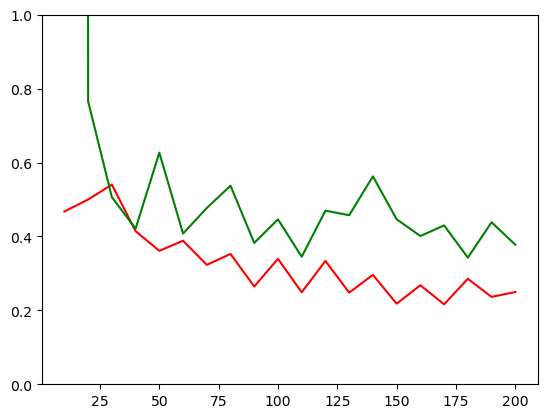

In [26]:
plt.plot(counter, train_history, color='r', label='Train')
plt.plot(counter, val_history, color='g', label='Validation')
plt.ylim(0, 1)
plt.show()

In [25]:
train_history

[0.46750205755233765,
 0.4998623728752136,
 0.540237545967102,
 0.41419804096221924,
 0.3610725402832031,
 0.3883932828903198,
 0.3231580853462219,
 0.3525652587413788,
 0.26461148262023926,
 0.3393959105014801,
 0.2489050328731537,
 0.33381229639053345,
 0.24788039922714233,
 0.2960507571697235,
 0.21804244816303253,
 0.268040269613266,
 0.2162335366010666,
 0.28532618284225464,
 0.23643992841243744,
 0.24966217577457428]

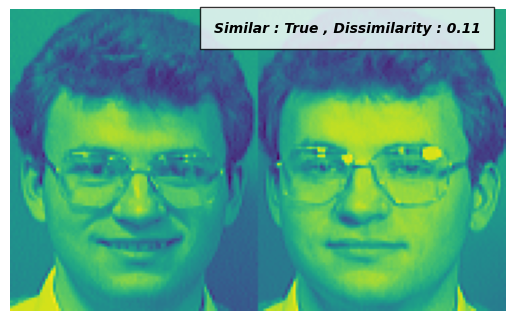

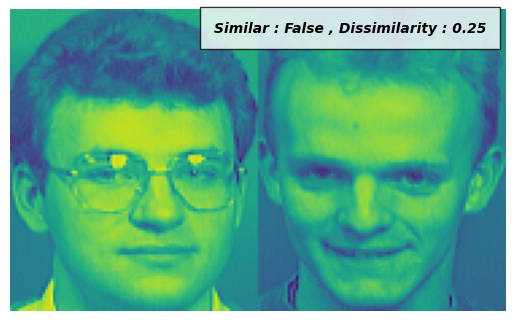

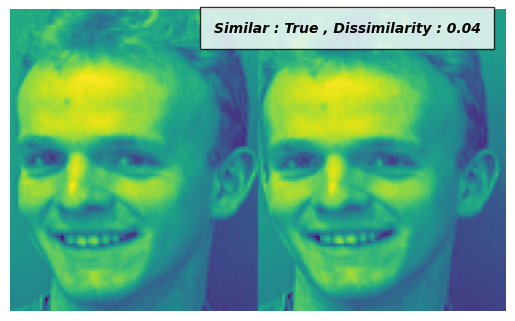

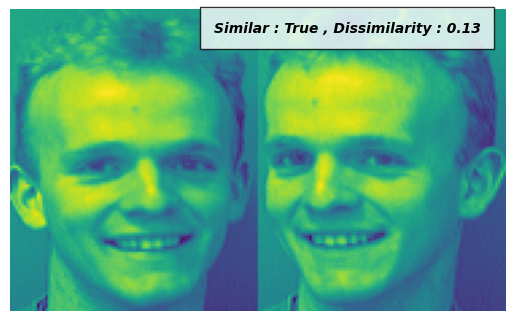

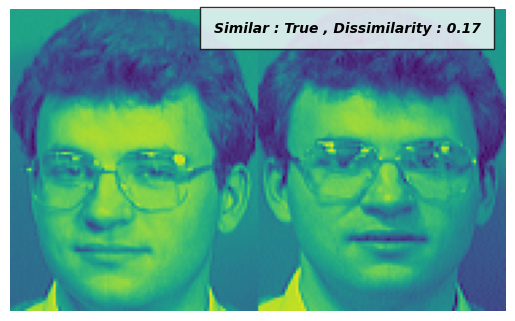

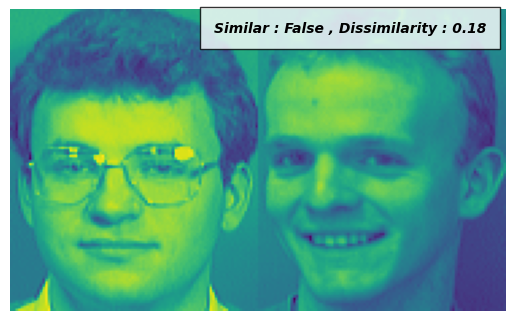

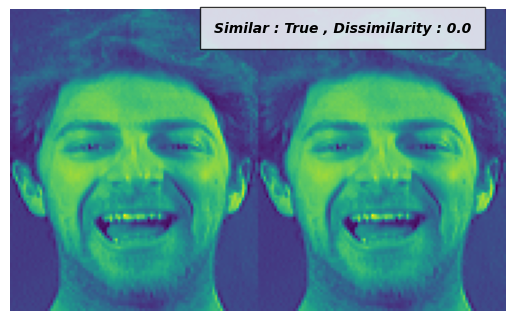

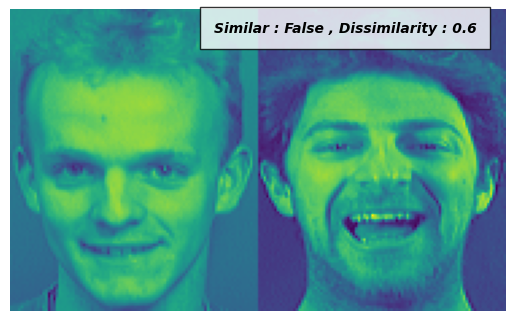

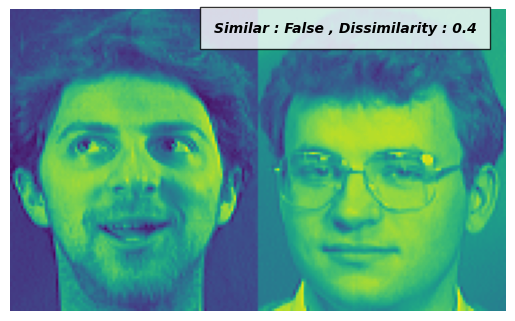

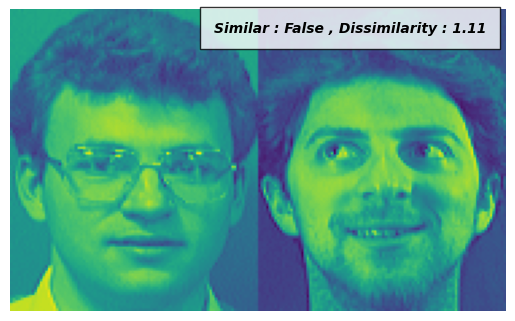

In [27]:
test_batch = load_a_batch(10,test_img_dict)
img_1,img_2,label = stack(test_batch)
out1,out2 = neural_network(img_1,img_2)
dist = list(F.pairwise_distance(out1,out2))

for i in range(len(test_batch)):
    
    res = torch.cat((img_1[i].squeeze(), img_2[i].squeeze()), 1).float()
    pil_img = transforms.ToPILImage()(res)
    text = f"Similar : {bool(label[i].item())} , Dissimilarity : {round(dist[i].item(),2)}"
    imshow(res,text)


In [24]:
test_batch[0]

(tensor([[[128, 125, 126,  ..., 125, 126, 123],
          [127, 127, 124,  ..., 124, 124, 124],
          [127, 127, 124,  ..., 125, 124, 127],
          ...,
          [ 87, 102,  94,  ...,  87,  86,  87],
          [103, 105,  92,  ...,  88,  83,  87],
          [ 92,  92,  89,  ...,  84,  85,  85]]], dtype=torch.uint8),
 tensor([[[126, 127, 126,  ..., 125, 126, 125],
          [126, 129, 126,  ..., 125, 127, 125],
          [128, 124, 129,  ..., 124, 126, 124],
          ...,
          [ 86,  89,  91,  ...,  87,  87,  86],
          [101,  98,  97,  ...,  86,  86,  86],
          [100,  98,  99,  ...,  87,  85,  89]]], dtype=torch.uint8),
 True)